In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
youtube_data = pd.read_csv("youtube_dataset.csv", index_col="video_id")

In [3]:
youtube_data.head()

,Unnamed: 0,published_at,title,channel_title,view_count,like_count,favorite_count,comment_count,duration,definition
video_id,,,,,,,,,,
uexN9gs5gvM,0,2023-05-04T19:01:39Z,Dei V x Myke Towers - Trending Remix (Official...,Dei V,14735004,117530.0,0,1076.0,00:04:33,hd
WXPfcRnz9Z8,1,2023-01-19T20:02:53Z,Trending - Dei V (Official Video),Dei V,6228419,62711.0,0,911.0,00:02:39,hd
K-mV_8aeQsk,2,2023-06-23T14:00:15Z,Most Unbelievable Moments Ever Caught On Camera !,Novella,7501791,38685.0,0,1138.0,00:11:04,hd
hplD4QyV4Q8,3,2019-02-24T03:00:05Z,Squash - Trending (Official Video),SquashVEVO,15445316,100024.0,0,2370.0,00:03:06,hd
XqHLbmM6Iew,4,2023-11-23T12:35:32Z,TRENDING રીધમ || ROHIT THAKOR || rohit thakor ...,SK OFFICIAL PUNAJ,1049158,14913.0,0,136.0,00:05:32,hd


### Step 1:
## Preprocessing

In [4]:
from datetime import timedelta

# Remove unnecessary columns
youtube_data.drop(['Unnamed: 0', 'favorite_count', 'definition', 'title', 'channel_title'], axis=1, inplace=True)

# Remove duplicates
youtube_data.drop_duplicates(inplace=True)

# Convert 'published_at' to datetime
youtube_data['published_at'] = pd.to_datetime(youtube_data['published_at'])

# Convert 'duration' to seconds
def duration_to_seconds(duration):
    try:
        time_parts = duration.split(':')
        return int(time_parts[0]) * 3600 + int(time_parts[1]) * 60 + int(time_parts[2])
    except:
        return None

youtube_data['duration_seconds'] = youtube_data['duration'].apply(duration_to_seconds)

# Drop the original 'duration' column
youtube_data.drop('duration', axis=1, inplace=True)

# Check for missing values
missing_values = youtube_data.isnull().sum()

# Display the number of missing values for each column
missing_values


published_at         0
view_count           0
like_count          21
comment_count       16
duration_seconds     0
dtype: int64

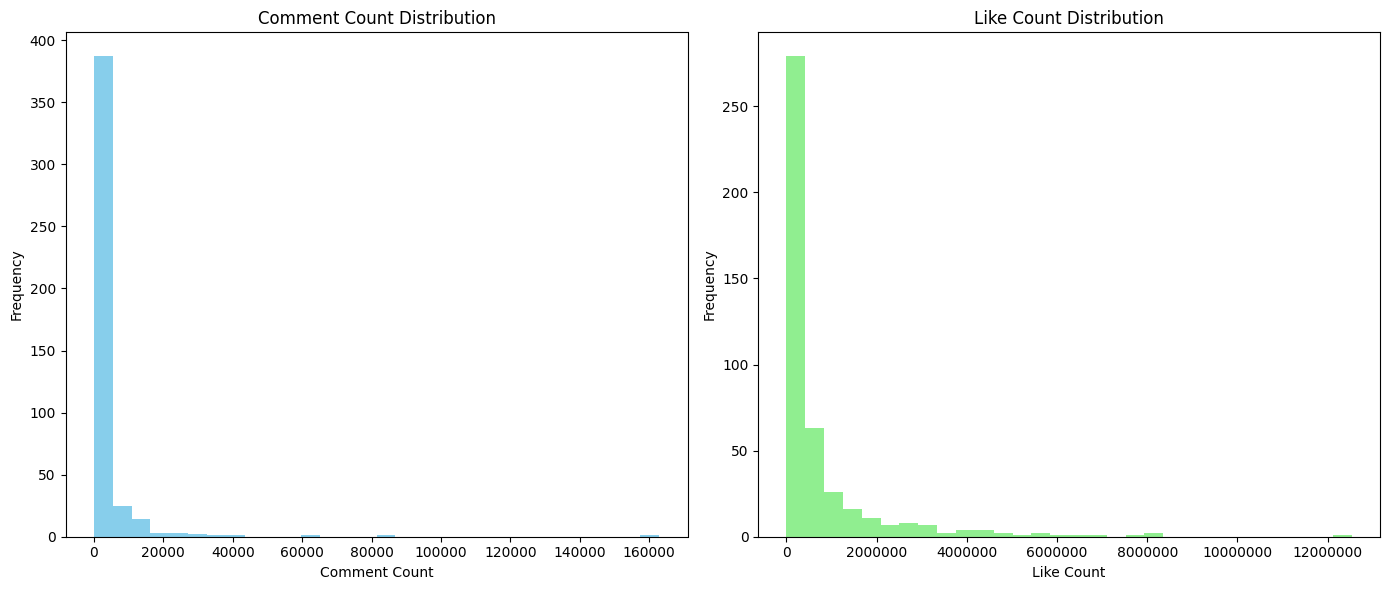

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for comment_count
axs[0].hist(youtube_data['comment_count'], bins=30, color='skyblue')
axs[0].set_title('Comment Count Distribution')
axs[0].set_xlabel('Comment Count')
axs[0].set_ylabel('Frequency')

# Histogram for like_count
axs[1].hist(youtube_data['like_count'], bins=30, color='lightgreen')
axs[1].set_title('Like Count Distribution')
axs[1].set_xlabel('Like Count')
axs[1].set_ylabel('Frequency')
axs[1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

We can detect a few outliers in the data, with a high number of comments and likes.

With that kind of distribution, filling missing values with median will be better

In [6]:
youtube_data['like_count'] = youtube_data['like_count'].fillna(youtube_data['like_count'].median())
youtube_data['comment_count'] = youtube_data['comment_count'].fillna(youtube_data['comment_count'].median())

In [7]:
# Calculate the ratio of likes per view and comments per view
youtube_data['likes_per_view'] = youtube_data['like_count'] / youtube_data['view_count']
youtube_data['comments_per_view'] = youtube_data['comment_count'] / youtube_data['view_count']

youtube_data

,published_at,view_count,like_count,comment_count,duration_seconds,likes_per_view,comments_per_view
video_id,,,,,,,
uexN9gs5gvM,2023-05-04 19:01:39+00:00,14735004,117530.0,1076.0,273,0.007976,0.000073
WXPfcRnz9Z8,2023-01-19 20:02:53+00:00,6228419,62711.0,911.0,159,0.010069,0.000146
K-mV_8aeQsk,2023-06-23 14:00:15+00:00,7501791,38685.0,1138.0,664,0.005157,0.000152
hplD4QyV4Q8,2019-02-24 03:00:05+00:00,15445316,100024.0,2370.0,186,0.006476,0.000153
XqHLbmM6Iew,2023-11-23 12:35:32+00:00,1049158,14913.0,136.0,332,0.014214,0.000130
...,...,...,...,...,...,...,...
7fsC9VZdqhk,2023-05-28 07:34:42+00:00,2979104,128917.0,673.0,39,0.043274,0.000226
DNToKKQQD2g,2022-11-22 19:08:02+00:00,5379,191.0,8.0,26,0.035508,0.001487
XTqkKEkbLGY,2022-09-01 01:52:54+00:00,3560758,77187.0,828.0,14,0.021677,0.000233


In [8]:
from scipy import stats

# Calculating Z-scores for 'likes_per_view' and 'comments_per_view'
youtube_data['z_likes_per_view'] = stats.zscore(youtube_data['likes_per_view'])
youtube_data['z_comments_per_view'] = stats.zscore(youtube_data['comments_per_view'])

# Filter for outliers: considering outliers as being 3 standard deviations away from the mean
outliers_likes = youtube_data[np.abs(youtube_data['z_likes_per_view']) > 3]
outliers_comments = youtube_data[np.abs(youtube_data['z_comments_per_view']) > 3]

# Displaying the number of outliers detected
num_outliers_likes = outliers_likes.shape[0]
num_outliers_comments = outliers_comments.shape[0]

num_outliers_likes, num_outliers_comments


(7, 7)